In [2]:
#Code to read in variables from the nc files created when grads files are converted using cdo 
#Command is:   cdo -f nc import_binary file.ctl ofile.nc 
#Had to adapt Glen's .ctl files to put distances in meters, even though they're called lat and lon the variables are actually 
from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset
from scipy.io import netcdf
from scipy.spatial import distance
import pyproj
from pyproj import Proj, transform
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt
from pylab import savefig
import datetime
import pandas
import glob
import scipy

In [3]:
#Read in SnowModel nc files 

def Readin_SnowModel_0916(forcing,year,variable):
    """2009 to 2016 yearly files. Variables are 'sden' or 'snod'"""
    yearname='%02d' %(int(str(year)[(len(str(year))-2):]))
    filepath='/Users/samanthabuzzard/Liston_May_v2/sm_oib_2009-2016/'+forcing+'/'+'sm_'+str(yearname)+'/'
    f = Dataset(filepath+variable+'_ease_grid.nc', 'r')
    lon= f.variables['lon'][:]
    lat=f.variables['lat'][:]
    snow=f.variables[variable][:]
    x1, y1=np.meshgrid(lon, lat)
    return snow,x1,y1

def Readin_SnowModel_36(forcing,variable):
    """Have 1st Aug 1980 for 36 years, includes leap years total of 13149 days. Variables are 'sden' or 'snod'"""  
    filepath='/Users/samanthabuzzard/Liston_May_v2/sm_36yrs/'+forcing+'/'
    f = Dataset(filepath+variable+'_ease_grid.nc', 'r')
    snow=f.variables[variable][:]
    lon= f.variables['lon'][:]
    lat=f.variables['lat'][:]
    x1, y1=np.meshgrid(lon, lat)
    return snow,x1,y1



In [115]:
#Get daily data 
def Get_daily_data_0916(snow,year,month,day):
    #Model runs for 365 days regardless of leap year
    if month in range(1,8,1):
        d0 = datetime.date(year-1, 8, 1)
    else:
        d0 = datetime.date(year, 8, 1)
    d1 = datetime.date(year,month,day)
    delta = d1 - d0
    date=delta.days
    snow_daily=snow[date,:,:]         
    return snow_daily
    
def Get_daily_data_36(snow,year,month,day):
    d0 = datetime.date(1980, 8, 1)
    d1 = datetime.date(year, month, day)
    delta = d1 - d0
    date=delta.days
    snow_daily=snow[date,:,:]
    return snow_daily    


In [59]:
snow,x1,y1=Readin_SnowModel_0916('erai',2010,'snod')
snow_day=Get_daily_data_0916(snow,2010,3,31)

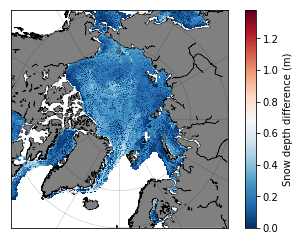

In [60]:
Replace6931=pyproj.Proj("+proj=laea +lat_0=90 +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs"); #close to polar stereographic but different latitude of origin/ central meridian so adapted above
inProj = Proj(init='epsg:3408')#Replace6931  
outProj = Proj(init='epsg:4326') #lat lon was using 4326
xx, yy = transform(inProj,outProj,x1,y1)

m = Basemap(projection='npstere',boundinglat=60,lon_0=0,resolution='l')
x2,y2=m(xx,yy)
m.drawparallels(np.arange(60,90,10), linewidth = 0.25, linestyle='solid', zorder=8)
m.drawmeridians(np.arange(0.,360.,30.), linewidth = 0.25, zorder=8)
m.drawcoastlines(linewidth=0.5)
m.pcolormesh(x2, y2, snow_day, cmap='RdBu_r')
m.fillcontinents(color='grey')
#plt.axis([lon.min(), lon.max(), lat.min(), lat.max()])
cb = plt.colorbar()
cb.set_label('Snow depth difference (m)')
plt.show() 
plt.savefig('test_grads.jpeg')

In [67]:
Replace6931=pyproj.Proj("+proj=laea +lat_0=90 +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs"); #close to polar stereographic but different latitude of origin/ central meridian so adapted above
inProj = Proj(init='epsg:3408')#Replace6931  
outProj = Proj(init='epsg:4326') #lat lon was using 4326
xx, yy = transform(inProj,outProj,x1,y1)

x1, y1=np.meshgrid(lon, lat)


NameError: name 'lon' is not defined

/Users/samanthabuzzard/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:583: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


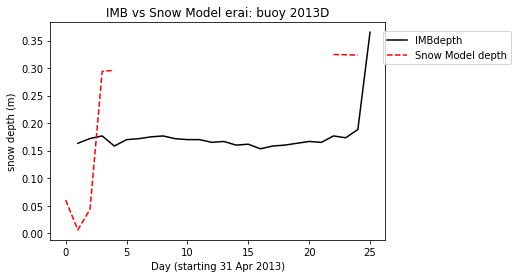

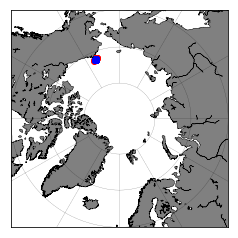

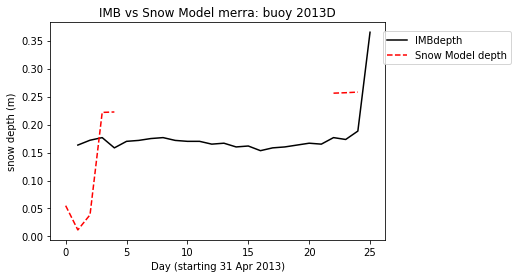

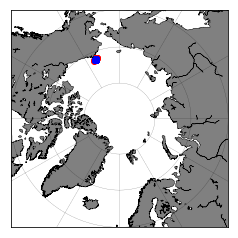

In [ ]:
def Compare_with_buoy(buoy_name, forcing, modelrun, buoys):
    buoy_lats=[]
    buoy_lons=[]
    buoy_snow=[]
    buoy_year=[]
    buoy_month=[]
    buoy_day=[]
    modelled_snow=[]
    distances=[]
    model_x=[]
    model_y=[]
    month_numbers=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    if buoys=='CRREL':
            Buoy_files=glob.glob('/Volumes/n4_cpdata/scb/SNOW_DATA/BUOYS/CRREL/SORTED/av_'+buoy_name+'*.txt')
            figure_path='/Volumes/n4_cpdata/scb/SNOW_DATA/SNOWMODEL_EASE/VALIDATION/BUOYS/CRREL/'

    for item in Buoy_files:
        data=(np.loadtxt(item))
        buoy_lats.append(data[0])
        buoy_lons.append(data[1])
        buoy_snow.append(data[2])
        buoy_year.append(item[len(item)-12:len(item)-8])
        buoy_month.append(item[len(item)-8:len(item)-6])
        buoy_day.append(item[len(item)-6:len(item)-4])
        
    if modelrun=='36yrs':
        snow, x1, y1=Readin_SnowModel_36(forcing,'snod') #Takes too long to open to do this every time (reopen 09_16 every time as year may change)

    for point in range(0,len(buoy_snow),1):
        if modelrun=='09_16':
            snow, x1, y1=Readin_SnowModel_0916(forcing,buoy_year[point],'snod')
            snow_model=Get_daily_data_0916(snow,int(buoy_year[point]),int(buoy_month[point]),int(buoy_day[point]))
        if modelrun=='36yrs':
            snow_model=Get_daily_data_36(snow,int(buoy_year[point]),int(buoy_month[point]),int(buoy_day[point]))
        if (buoy_lons[point]>180 or buoy_lons[point]<-180 or buoy_lats[point]>90 or buoy_lats[point]<-90):
            print('data invalid for '+str(buoy_name)+' '+buoy_day[point]+'/'+buoy_month[point]+'/'+buoy_year[point])
            continue
        XX,YY = np.meshgrid(np.arange(snow_model.shape[1]),np.arange(snow_model.shape[0]))
        table = np.vstack((XX.ravel(),YY.ravel())).T
        x2, y2=np.meshgrid(buoy_lons[point], buoy_lats[point])
        inProj = Proj(init='epsg:3408')
        outProj = Proj(init='epsg:4326') #lat lon was using 4326
        xx, yy = transform(outProj,inProj,x2,y2)
        model_grid = list( zip(np.ravel(x1), np.ravel(y1)) ) 
        target_pts = [xx[0][0], yy[0][0]] 
        if (str(target_pts[0])=='nan' or str(target_pts[1])=='nan'):
            continue
        distance, index = scipy.spatial.cKDTree(model_grid).query(target_pts)  #cKDTree is faster than KDTree for simple queries like this
        # the nearest model location (in lat and lon)
        #model_loc_coord = [coord for i, coord in enumerate(model_grid) if i==index]
        nearest_x=table[index][0]
        nearest_y=table[index][1]
        modelled_snow.append(snow_model[nearest_x, nearest_y])
        distances.append(distance)
        if distance>25000:
            print('WARNING- comparison point more than 25km away for day '+str(buoy_name)+' '+buoy_day[point]+'/'+buoy_month[point]+'/'+buoy_year[point])
        
        model_x.append(x1[0][nearest_x])
        model_y.append(y1[nearest_y][0])

    plt.plot(buoy_snow[:], label='IMBdepth', color='black') 
    plt.plot(modelled_snow,'--', label='Snow Model depth', color='red')# color=colours[count] if plotting several for one year
    plt.xlabel('Day (starting '+str(buoy_day[0])+' '+month_numbers[int(buoy_month[0])]+' '+str(buoy_year[0])+')')
    plt.ylabel('snow depth (m)')
    plt.title('IMB vs Snow Model '+forcing+': buoy '+buoy_name)
    plt.legend(loc='lower right', bbox_to_anchor=(1.39, 0.785))
    plt.savefig(figure_path+buoy_name+'_'+forcing+'_'+modelrun+".png",dpi=100,bbox_inches='tight')
    plt.show()
    plt.clf()
    
    m = Basemap(projection='npstere',boundinglat=60,lon_0=0,resolution='l')
    m.drawparallels(np.arange(60,90,10), linewidth = 0.25, linestyle='solid', zorder=8)
    m.drawmeridians(np.arange(0.,360.,30.), linewidth = 0.25, zorder=8)
    m.drawcoastlines(linewidth=0.5)
    x4,y4=m(buoy_lons,buoy_lats)
    m.scatter(x4,y4,marker='o',color='r')
    Replace6931=pyproj.Proj("+proj=laea +lat_0=90 +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs"); #close to polar stereographic but different latitude of origin/ central meridian so adapted above
    inProj = Proj(init='epsg:3408')#Replace6931  
    outProj = Proj(init='epsg:4326') #lat lon was using 4326
    x3, y3=np.meshgrid(model_x, model_y)
    xx3, yy3 = transform(inProj,outProj,x3,y3)
    xxx3,yyy3=m(xx3,yy3)
    m.scatter(np.ravel(xxx3),np.ravel(yyy3), s=10, marker='o',color='b')
    m.fillcontinents(color='grey')
    plt.savefig(figure_path+buoy_name+'_'+forcing+'_'+modelrun+"_map.png",dpi=100,bbox_inches='tight')
    plt.show() 
    plt.clf()
    
    
    


CRREL_buoys=['2013D', '2013A', '2013B', '2013C', '2013E', '2013F', '2013G', '2013H', '2013I', '2014B', '2014C', '2014D', '2014E', '2014I' ]
for buoy in range(0, len(CRREL_buoys), 1):
    Compare_with_buoy(CRREL_buoys[buoy], 'erai', '09_16', 'CRREL')
    Compare_with_buoy(CRREL_buoys[buoy], 'merra', '09_16', 'CRREL')
    Compare_with_buoy(CRREL_buoys[buoy], 'erai', '36yrs', 'CRREL')
    Compare_with_buoy(CRREL_buoys[buoy], 'merra', '36yrs', 'CRREL')



IndexError: index 130321 is out of bounds for axis 0 with size 130321

In [141]:
str(target_pts[0])=='nan'

True

In [125]:
distance

4248.085867999703

In [109]:
distance

12037.32472603615

In [103]:
buoy_lons

[-82.889099999999999,
 -82.889258333333331,
 -82.889095833333343,
 -82.889058333333324,
 -82.88911250000001,
 -82.889075000000005,
 -82.88914583333333,
 -82.88914583333333,
 -82.889212499999999,
 -82.889158333333327,
 -82.889137500000004,
 -82.889133333333334,
 -82.889075000000005,
 -82.889087500000002,
 -82.889116666666666,
 -82.88911250000001,
 -82.888945833333324,
 -82.889066666666665,
 -82.889070833333335,
 -82.889025000000004,
 -82.889045833333327,
 -82.889237499999993,
 -82.889195833333346,
 -82.889178260869571,
 -82.889233333333323,
 -82.889158333333327,
 -82.889075000000005,
 -82.889099999999999,
 -82.889121739130445,
 -82.889150000000001,
 -82.889208333333329,
 -82.889195833333332,
 -82.88922083333334,
 -82.889287500000009,
 -82.889229166666667,
 -82.889162499999998,
 -82.889212499999999,
 -82.889250000000004,
 -82.889150000000001,
 -82.889208333333329,
 -82.88914166666666,
 -82.889116666666666,
 -82.889187499999991,
 -82.889162499999998,
 -82.889162499999998,
 -82.88912499999